In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import signal, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings("ignore", message="covariance of constraints does not have full rank", category=ValueWarning)

In [2]:
def remove_outliers(data, csv_file, directory):

    print("Removing outliers from:", csv_file)
    
    # Identify and remove outliers using IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Align the DataFrame and Series before making the comparison
    lower_bound, _ = data.align(Q1 - 1.5 * IQR, axis=1, copy=False)
    upper_bound, _ = data.align(Q3 + 1.5 * IQR, axis=1, copy=False)
    
    # Find outliers
    outliers_mask = (data.lt(lower_bound) | data.gt(upper_bound)).any(axis=1)
    
    # Track the number of outliers
    outlier_count = outliers_mask.sum()
    
    # Display information about outliers
    if outlier_count > 0:
        print(f"File: {csv_file} - Total outliers: {outlier_count} - Directory: {directory}")
        print("Outliers count per metric:")
        print((data[outliers_mask]).count())
        print("Sample outlier values:")
        print(data[outliers_mask].head(5))  # Adjust the number of samples as needed
    
    # Remove outliers
    data = data[~outliers_mask]



# More attributes at: https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.JohansenTestResult.html#rdb8d6a7c069c-1
# Johansen’s test is a statistical procedure used to determine 
# if three or more time series are cointegrated. 
# It assesses the validity of a cointegrating relationship 
#  between time series variables. 
# If the test statistic is greater than the critical value, 
# it indicates a significant relationship.

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    print('Augmented Dickey-Fuller Test:')
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# Granger’s Causality Test

#Test relationship between different features
#tests the null hypothesis that the coefficients 
# of past values in the regression equation is zero.
# i.e.  whether one time series variable can predict another. 
# A low p-value (less than 0.05) implies that the null hypothesis 
# can be rejected, meaning that there is 
# a Granger causal relationship between the variables.

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    maxlag=12
    test = 'ssr_chi2test'

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def process_files(step_size, filter, devices, models, resources, root_directory):
    
    start_time = '2022-02-22 14:22:22'  # Choose a start time for your data
                
    for model in models:
        data_frames, csv_file_list = [], []
        for device in devices:
            device_directory = os.path.join(root_directory, model, device, filter, 'predictions')
            # print("Device directory:", device_directory)
            csv_files = [f for f in os.listdir(device_directory) if f.endswith(step_size + '.csv')]
            for csv_file in csv_files:
                file_path = os.path.join(device_directory, csv_file)
                data = pd.read_csv(file_path)

                # Remove unnecessary brackets
                data = data.replace(to_replace='\[\[|\]\]', value='', regex=True)
                
                # remove_outliers(data, csv_file, directory)

                data_frames.append(data)
                csv_file_list.append((device_directory, csv_file))
        
        return pd.concat(data_frames)


def get_step_size_name(step_size):
    step_size_dict = {'1Step': '1-step', '2Step': '2-step', '5Step': '5-step', '10Step': '10-step', '15Step': '15-step'}
    return step_size_dict.get(step_size)

def get_resource_name(resource):
    resources_dict = {'cpu_user_time_diff':'CPU-User-Sec', 'cpu_idle_time_diff':'CPU-Idle-Sec', 'cpu_system_time_diff':'CPU-Sys-Sec', 'memory':'Memory-%'}
    return resources_dict.get(resource)

def get_filter_name(filter_name):
    filter_dict = {'':'No Filter', '_sg_5_2' : 'Sav. Golay', '_sma_2': 'SMA', '_ema_1':'EMA' }
    return filter_dict.get(filter_name)

def analyze_data(df):
    # Calculate volatility, skewness, kurtosis, seasonal decomposition, 
    # and Granger's causality
    
    # Calculate volatility
    # These metrics measure the degree of variation in the data over time. 
    # High volatility indicates significant fluctuations, 
    # while low volatility suggests more stable data.
    rolling_volatility = df.rolling(window=10).std()
    
    ewma_volatility = df.ewm(span=10).std()
    
    # Calculate Skewness: measures the asymmetry of the probability distribution, 
    skewness = df.skew()
    # while kurtosis measures the "tailedness" of the distribution. 
    kurtosis = df.kurt()

    # These can provide insights into the underlying
    #  characteristics of the data distribution.
    

    # Decomposition into trend, seasonal and residual components
    decompositions = {}
    for column in df.columns:
        decompositions[column] = seasonal_decompose(df[column], period=int(5))


    
    # Granger's causality matrix
    grangers_matrix = grangers_causation_matrix(df, variables=df.columns)
    

    # Cointegration test
    cointegration_test(df)

    # Multicollinearity when two or more predictor variables are highly correlated. This can lead to unstable estimates and might cause the covariance matrix to lose rank
    # done due to the warning: covariance of constraints does not have full rank
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)

    return decompositions, skewness, kurtosis, grangers_matrix, rolling_volatility, ewma_volatility



def plot_results(df, decomposition, key):
    # Set the seaborn style
    sns.set_style('whitegrid')

    # Periodogram
    plot_periodogram(df)

    # Autocorrelation
    corr = np.correlate(df, df, mode='full')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(corr)
    ax.set_xlabel('Lag', fontsize=14)
    ax.set_ylabel('Autocorrelation', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, which='both')
    plt.show()

    # Histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(df, kde=True, ax=ax)
    ax.set_xlabel('Value', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

    # Seasonal decomposition plots
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))
    axes[0].set_title(key + ' - Observed', fontsize=16)
    axes[0].plot(decomposition[key].observed)
    axes[1].set_title(key + ' - Trend', fontsize=16)
    axes[1].plot(decomposition[key].trend)
    axes[2].set_title(key + ' - Seasonal', fontsize=16)
    axes[2].plot(decomposition[key].seasonal)
    axes[3].set_title(key + ' - Residual', fontsize=16)
    axes[3].plot(decomposition[key].resid)

    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=12)

    fig.tight_layout()
    plt.show()

    # ACF and PACF
    acf_values = acf(df, nlags=40)
    pacf_values = pacf(df, nlags=40, method='ywm')

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    plot_acf(df, ax=ax1)
    ax1.set_title('Autocorrelation', fontsize=18)
    ax1.set_xlabel('Lag', fontsize=14)
    ax1.set_ylabel('ACF', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    plot_pacf(df, method='ywm', ax=ax2)
    ax2.set_title('Partial Autocorrelation', fontsize=18)
    ax2.set_xlabel('Lag', fontsize=14)
    ax2.set_ylabel('PACF', fontsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    fig.tight_layout()
    plt.show()


    


def plot_heatmap(data, annot=True, cmap='seismic_r', title=None, xlabel=None, ylabel=None):
    """
    Plots a heatmap for the given data.

    Parameters:
    data (DataFrame): A pandas DataFrame containing the data for the heatmap.
    annot (bool): If True, write the data value in each cell. Default is True.
    cmap (str): The color map to use for the heatmap. Default is 'seismic_r'.
    title (str): Title of the heatmap. Default is None.
    xlabel (str): Label for the x-axis. Default is None.
    ylabel (str): Label for the y-axis. Default is None.
    """
    plt.figure()
    sns.heatmap(data, annot=annot, cmap=cmap)
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    
    plt.show()

def prepare_heatmap_data(df, resource):
    heatmap_data = pd.DataFrame()
    for column in df.columns:
        if resource in column:
            heatmap_data[column] = df[column]
    return heatmap_data

def print_results(skewness, kurtosis, grangers_matrix, rolling_volatility, ewma_volatility):

    print("Rolling volatility:\n", rolling_volatility.head(10))
    
    print("Exponential Weighted Moving Avereage volatility:\n", ewma_volatility.head(10))
    # Calculate skewness and kurtosis
    
    print("Skewness:\n", skewness.head(10))
    
    print("Kurtosis:\n", kurtosis.head(10))

    print('Granger Causation Matrix:', grangers_matrix)




def plot_periodogram(df, resource, color):
    # Perform the periodogram
    f, Pxx_den = signal.periodogram(df)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed
    ax.semilogy(f[1:], Pxx_den.T[1:], color=color)  # Change the color to dark purple
    ax.set_ylim(bottom=1e-5)  # Only show values above 10^-8
    
    # Set the title and labels
    ax.set_title(f'Power Spectral Density ({resource})', fontsize=18)
    ax.set_xlabel('Frequency [Hz]', fontsize=14)
    ax.set_ylabel('Power Spectral Density [V^2/Hz]', fontsize=14)
    
    # Customize tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add gridlines
    ax.grid(True, which='both')
    

def analyze_and_plot(step_sizes, filtes, devices, models, resources, root_directory='Results'):
    data_frames = []
    dfs = {}
    colors = ['#469990', '#aaffc3', '#ffd8b1', '#dcbeff']
    for step_size_dir in step_sizes:
        for filter_dir, color in zip(filtes, colors):
            
            # Create the plot
            fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed
                        
            for device in devices:
                for model in models:
                    

                    df = process_files(step_size_dir, filter_dir, devices, models, resources, root_directory)
                    # Convert all columns to numeric data types
                    for column in df.columns:
                        df[column] = pd.to_numeric(df[column], errors='coerce')
                    df = df.dropna()
                    
                    # Perform your analysis and plotting here
                    # decomposition, skewness, kurtosis, grangers_matrix, rolling_volatility, ewma_volatility = analyze_data(df)
                    
                    # # Plot Granger causality matrix as a heatmap
                    # plot_heatmap(grangers_matrix, title='Granger Causality Matrix', xlabel='X variable', ylabel='Y variable')

                     
                    
                    for col in df.columns:
                        if 'user' in col and 'obs' in col or 'memory' in col and 'obs' in col :
                    
                            dfs[col] = df[col]

        for res in ['user', 'memory']:
               
            for resource, df in dfs.items():

                if res in resource:

                    f, Pxx_den = signal.periodogram(df)

                    try:
                        ax.semilogy(f, Pxx_den.T, color=color)
                    except:
                        ax.semilogy(f, Pxx_den, color=color)
            
            ax.set_ylim(bottom=1e-5)  # Only show values above 10^-5
            
            # Set the title and labels
            ax.set_title(f'Power Spectral Density ({res})', fontsize=18)
            ax.set_xlabel('Frequency [Hz]', fontsize=14)
            ax.set_ylabel('Power Spectral Density [V^2/Hz]', fontsize=14)
            
            # Customize tick label font sizes
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            # Add gridlines
            ax.grid(True, which='both')
            
            # Show the plot
            plt.show()

                        # plot_results(df[resource], decomposition, resource)

                    # data_frames.append(df)

    # # Combine data for heatmap plot
    # df_combined = pd.concat(data_frames)

    # # Plot heatmaps comparing the distribution of each resource and sequence type for selected datasets
    # for resource in resources:
    #     # Organize data per resource for heatmap
    #     heatmap_data = prepare_heatmap_data(df_combined, resource)
    #     plot_heatmap(heatmap_data, annot=True, cmap='seismic_r', title=resource)

cpu_user_time_diff


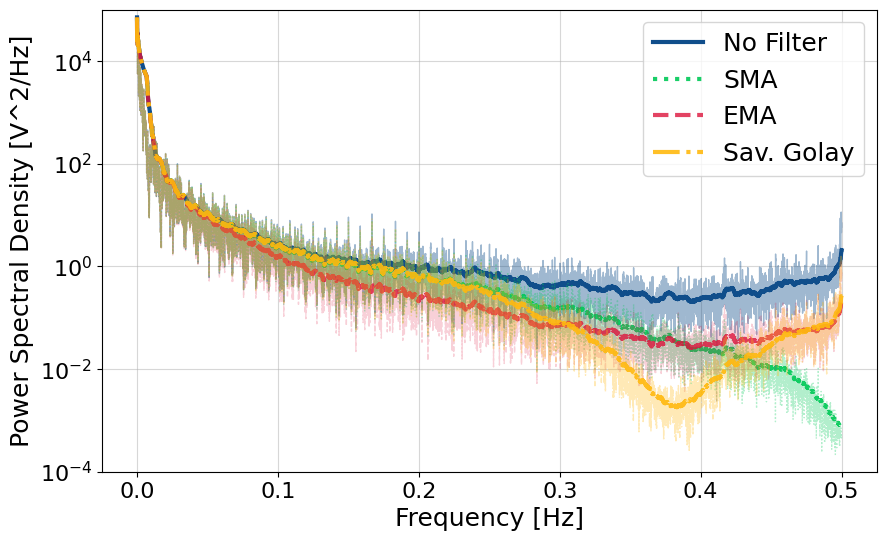

cpu_system_time_diff


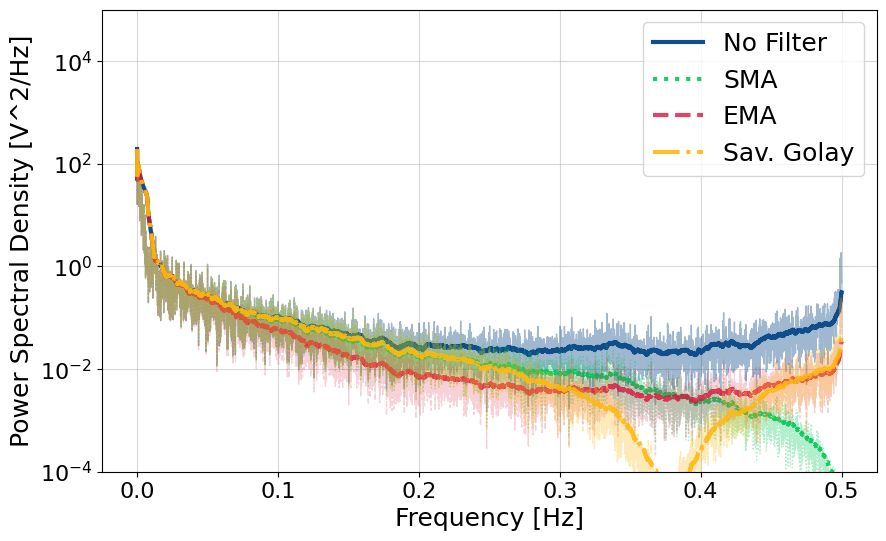

cpu_idle_time_diff


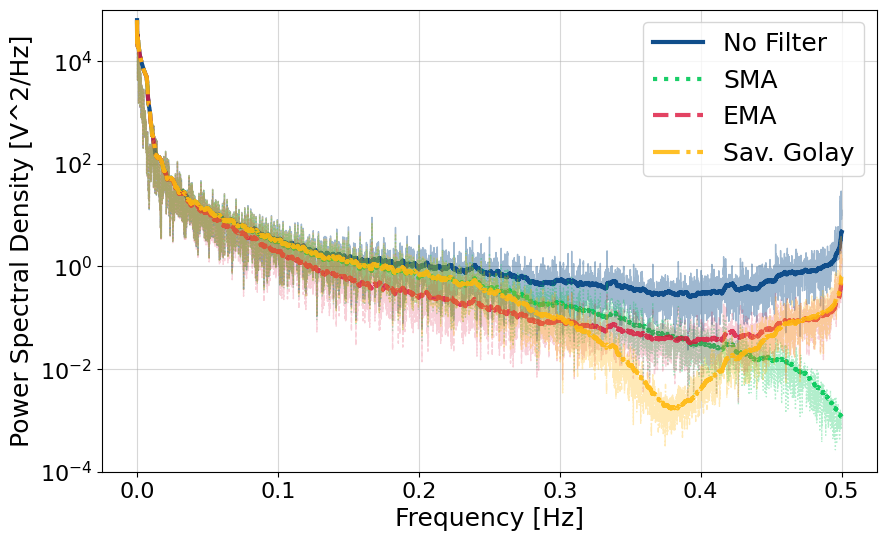

memory


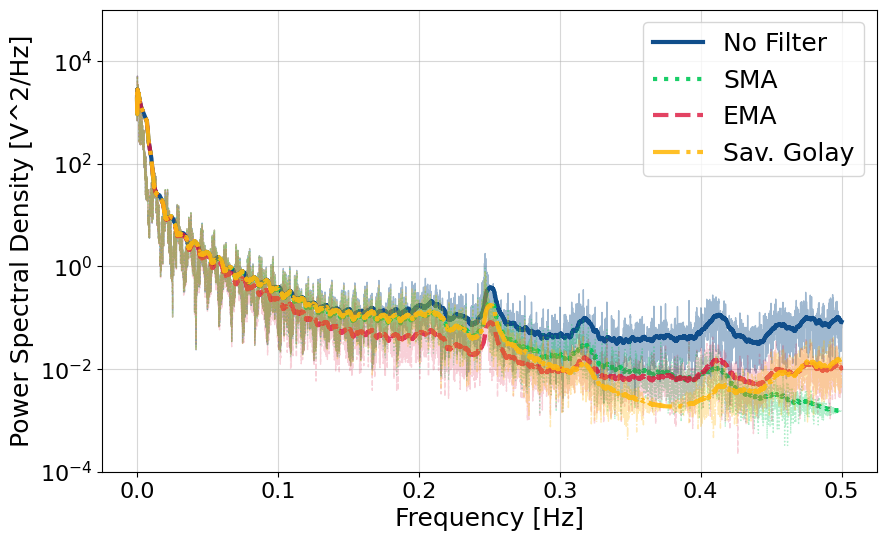

In [6]:
import re

def parse_float(value):
    try:
        if isinstance(value, str):
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

root_directory = 'Results'
models = ['Encoder-Decoder']
devices = ['RPi4B8GB']
step_sizes = ['1Step']
sequence_types = ["random"]
filters_dir = ['','_sma_2','_ema_1','_sg_5_2']
resources = ['cpu_user_time_diff', 'cpu_system_time_diff', 'cpu_idle_time_diff', 'memory']

colors = ['#104E8B', '#00C957', '#DC143C', '#FFB90F']
styles = ['-', ':', '--', '-.']
alfas = [0.9, 0.8, 0.7, 0.8]
for res in resources:
    print(res)
    fig, ax = plt.subplots(figsize=(10, 6))

    for filter_dir, color, style, alfa in zip(filters_dir, colors, styles, alfas):
        df = None
        for device in devices:
            for model in models:
                df = process_files(step_size_dir, filter_dir, devices, models, resources, root_directory)
                df = df.dropna()
                df = df.applymap(parse_float)
                

        # Get the correct column name for the current resource and filter
        column_name = f"{res}{filter_dir}_obs{filter_dir}"
        
        # Select the current resource from the dataframe
        resource_data = df[column_name]

        f, Pxx_den = signal.periodogram(resource_data)
        
        filter = get_filter_name(filter_dir)

        
        ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(4, min_periods=1).mean(), color=color, linestyle=style, alpha=alfa-0.5, linewidth=1)
        # ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(15, min_periods=1).mean(), color=color, linestyle=style, alpha=alfa, linewidth=2)
        ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(200, min_periods=1).mean(), color=color, label= filter, linestyle=style, alpha=alfa+0.1, linewidth=3)
    
    ax.set_ylim(bottom=1e-4,top=1e5)
    # ax.set_title(f'Power Spectral Density ({res})', fontsize=18)
    ax.set_xlabel('Frequency [Hz]', fontsize=18)
    ax.set_ylabel('Power Spectral Density [V^2/Hz]', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # logarthimic grid
    ax.set_yscale('log')
    ax.grid(alpha=0.5)

    ax.legend(fontsize=18)
    

    plt.show()

cpu_system_time_diff


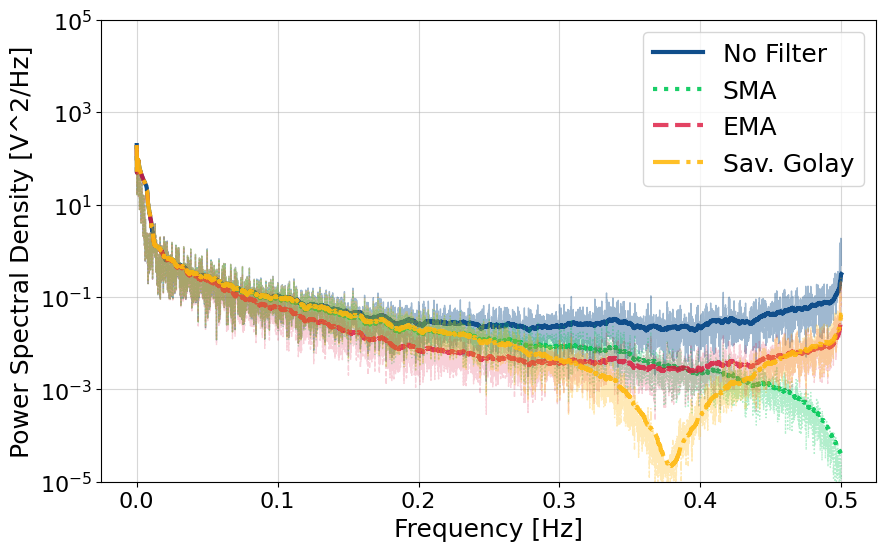

In [9]:
import re

def parse_float(value):
    try:
        if isinstance(value, str):
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

root_directory = 'Results'
models = ['Encoder-Decoder']
devices = ['RPi4B8GB']
step_sizes = ['1Step']
sequence_types = ["random"]
filters_dir = ['','_sma_2','_ema_1','_sg_5_2']
resources = ['cpu_system_time_diff']

colors = ['#104E8B', '#00C957', '#DC143C', '#FFB90F']
styles = ['-', ':', '--', '-.']
alfas = [0.9, 0.8, 0.7, 0.8]
for res in resources:
    print(res)
    fig, ax = plt.subplots(figsize=(10, 6))

    for filter_dir, color, style, alfa in zip(filters_dir, colors, styles, alfas):
        df = None
        for device in devices:
            for model in models:
                df = process_files(step_size_dir, filter_dir, devices, models, resources, root_directory)
                df = df.dropna()
                df = df.applymap(parse_float)
                

        # Get the correct column name for the current resource and filter
        column_name = f"{res}{filter_dir}_obs{filter_dir}"
        
        # Select the current resource from the dataframe
        resource_data = df[column_name]

        f, Pxx_den = signal.periodogram(resource_data)
        
        filter = get_filter_name(filter_dir)

        
        ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(4, min_periods=1).mean(), color=color, linestyle=style, alpha=alfa-0.5, linewidth=1)
        # ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(15, min_periods=1).mean(), color=color, linestyle=style, alpha=alfa, linewidth=2)
        ax.semilogy(f[1:], pd.DataFrame(Pxx_den[1:]).rolling(200, min_periods=1).mean(), color=color, label= filter, linestyle=style, alpha=alfa+0.1, linewidth=3)
    
    ax.set_ylim(bottom=1e-5,top=1e5)
    # ax.set_title(f'Power Spectral Density ({res})', fontsize=18)
    ax.set_xlabel('Frequency [Hz]', fontsize=18)
    ax.set_ylabel('Power Spectral Density [V^2/Hz]', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # logarthimic grid
    ax.set_yscale('log')
    ax.grid(alpha=0.5)

    ax.legend(fontsize=18)
    

    plt.show()